In [1]:
# Setup
import os
from dotenv import load_dotenv, find_dotenv

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

DBUNAME = os.environ.get("DBUNAME")
DBPASSWORD = os.environ.get("DBPASSWORD")
DBHOST = os.environ.get("DBHOST")
DBPORT = os.environ.get("DBPORT")
DBNAME = os.environ.get("DBNAME")

import sqlalchemy
import psycopg2

connection_str = 'postgresql+psycopg2://'+DBUNAME+':'+DBPASSWORD+'@'+DBHOST+':'+DBPORT+'/'+DBNAME

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from matplotlib import rcParams

In [4]:
try:
    engine = sqlalchemy.create_engine(connection_str)
    conn = engine.connect()
except:
    print('Database connection error - check creds')

# Get Data

In [6]:
pd.read_sql(
"""
select * from stg_ais_agg
where country='fj'
"""
,con=engine)

,date,region,country,cargo_uniq_mmsi_count,cargo_time_in_port_seconds,tanker_uniq_mmsi_count,tanker_time_in_port_seconds,fishing_uniq_mmsi_count,fishing_time_in_port_seconds,leisure_uniq_mmsi_count,leisure_time_in_port_seconds
0,2018-12-01,melanesia,fj,96623,8225504,41771,3856916,201239,28164121,3329,4799311
1,2019-01-01,melanesia,fj,104295,10516204,26042,4177227,217866,35000647,6787,6298000
2,2019-02-01,melanesia,fj,82977,8305678,28625,2650677,196432,23106864,25650,8546026
3,2019-03-01,melanesia,fj,117188,15045278,24740,4392659,358707,49505344,17772,7990159
4,2019-04-01,melanesia,fj,141222,12174899,11183,2482212,368514,70849062,16327,6092530
5,2019-05-01,melanesia,fj,106596,9403147,19119,3024458,390371,58249241,38041,11148567
6,2019-06-01,melanesia,fj,83840,6578942,17326,3442603,144426,34639958,85924,26548166
7,2019-07-01,melanesia,fj,81914,10430598,18347,3597682,94060,18868213,102252,44639877
8,2019-08-01,melanesia,fj,69661,7484365,26338,4357559,192471,35452028,141261,64657423
9,2019-09-01,melanesia,fj,43644,5953733,11440,1553838,129983,32943137,33062,17045484


In [13]:
data = pd.read_sql("""
with dates as (
    SELECT 
        date '2018-11-01' + interval '1' month * s.a AS date
    FROM generate_series(0,21,1) AS s(a)
)
,dates_countries as (
    select 
        d.date
        ,c.region
        ,c.country
    from dates d
    cross join (select distinct region, country from stg_trade_agg) c
)
,agg_port_calls as (
    select
        country
        ,date_trunc('month',"date-entry") as date
        ,sum(port_calls) as port_calls
    from public.ais_port_calls
    group by 1,2
)
,cpi_model as (
    select
        case 
            when country in ('fj','vn','sb') then 'melanesia'
            when country in ('ck','kir') then 'polynesia'
            when country in ('PW','pw','pl') then 'micronesia'
         end as region
        ,case when country = 'kir' then 'ki'
            else lower(country) end as country    
        ,case
            when lower(country) = 'fj' then to_date(date,'YYYY-MM')
            else to_date(date,'YYYY-MM-DD')
         end as date
        ,case
            when lower(country) = 'fj' and name = 'CPI_2014_Total' then cast(value as float)
            when lower(country) = 'pw' and name = 'CPI_2016_Total' then cast(value as float)
            when lower(country) = 'kir' and name = 'CPI_2006_ALL ITEMS' then cast(value as float)
            when lower(country) = 'sb' and name = 'CPI_2017_Total' then cast(value as float)
            else 0 end as cpi_total
        ,case
            when lower(country) = 'fj' and name = 'CPI_2014_Restaurants & Hotels' then cast(value as float)
            else 0 end as cpi_rest_hotel
    from public.country_metrics
    where true
        and lower(category) = 'cpi'
        and frequency = 'monthly'
        and lower(country) in ('fj','vn','ck','kir','pw','pl','sb')
--        and date between '2019-01-01' and '2019-12-01'    
)
,cpi_agg as (
    select 
        region
        ,country
        ,date
        ,sum(cpi_total) as cpi_total
        ,sum(cpi_rest_hotel) as cpi_rest_hotel
    from cpi_model 
    group by 1,2,3
    order by 1,2,3
)
,model as (
select 
    d.date as date_from
    ,d.date + interval '1 month' - interval '1 day' as date_to
    ,d.region
    ,d.country
    ,c.cpi_total
    ,c.cpi_rest_hotel
    ,t.trade_imports
    ,t.trade_exports
    ,t.trade_volume
    ,t.export_import_ratio
    ,cast(v.visitor_arrivals as float) as visitor_arrivals
    ,a.cargo_uniq_mmsi_count
    ,a.cargo_time_in_port_seconds
    ,a.tanker_uniq_mmsi_count
    ,a.tanker_time_in_port_seconds
    ,a.fishing_uniq_mmsi_count
    ,a.fishing_time_in_port_seconds
    ,a.leisure_uniq_mmsi_count
    ,a.leisure_time_in_port_seconds
    ,p.port_calls
from dates_countries d
left join cpi_agg c
    on left(cast(d.date as text),10) = left(cast(c.date as text),10)
    and d.country = c.country
left join stg_trade_agg t
    on left(cast(d.date as text),10) = cast(t.date as text)
    and d.country = t.country
left join stg_tourism_agg v 
    on left(cast(d.date as text),10) = left(cast(v.date as text),10)
    and d.country = v.country
left join stg_ais_agg a 
    on left(cast(d.date as text),10) = cast(a.date as text)
    and d.country = a.country
left join agg_port_calls p 
    on left(cast(d.date as text),10) = left(cast(p.date as text),10)
    and d.country = p.country
)
,wind as (
    select 
        -- dims
        date_from
        ,date_to
        ,region
        ,country
--        ,cpi_total
--        ,(cpi_total/(lag(cpi_total,12) over (partition by country order by date_from asc))-1) as cpi_growth_annualized
--        ,cpi_rest_hotel
--        ,(cpi_rest_hotel/(lag(cpi_rest_hotel,12) over (partition by country order by date_from asc))-1) as cpi_rh_growth_annualized
        -- targets
        ,trade_imports -- target 1
        ,trade_exports -- target 2
        ,trade_volume -- target 3
        -- lags of targets
        ,lag(trade_imports,1) over (partition by country order by date_from asc) as trade_imports_lag1
        ,lag(trade_exports,1) over (partition by country order by date_from asc) as trade_exports_lag1
        ,lag(trade_volume,1) over (partition by country order by date_from asc) as trade_volume_lag1

        -- features
        ,visitor_arrivals
        ,cargo_uniq_mmsi_count
        ,cargo_time_in_port_seconds
        ,tanker_uniq_mmsi_count
        ,tanker_time_in_port_seconds
        ,fishing_uniq_mmsi_count
        ,fishing_time_in_port_seconds
        ,leisure_uniq_mmsi_count
        ,leisure_time_in_port_seconds
        ,port_calls
        -- lags of features
        ,lag(visitor_arrivals,1) over (partition by country order by date_from asc) visitor_arrivals_lag1        
        ,lag(cargo_uniq_mmsi_count,1) over (partition by country order by date_from asc) cargo_uniq_mmsi_count_lag1        
        ,lag(cargo_time_in_port_seconds,1) over (partition by country order by date_from asc) cargo_time_in_port_seconds_lag1        
        ,lag(tanker_uniq_mmsi_count,1) over (partition by country order by date_from asc) tanker_uniq_mmsi_count_lag1        
        ,lag(tanker_time_in_port_seconds,1) over (partition by country order by date_from asc) tanker_time_in_port_seconds_lag1        
        ,lag(fishing_uniq_mmsi_count,1) over (partition by country order by date_from asc) fishing_uniq_mmsi_count_lag1        
        ,lag(fishing_time_in_port_seconds,1) over (partition by country order by date_from asc) fishing_time_in_port_seconds_lag1        
        ,lag(leisure_uniq_mmsi_count,1) over (partition by country order by date_from asc) leisure_uniq_mmsi_count_lag1        
        ,lag(leisure_time_in_port_seconds,1) over (partition by country order by date_from asc) leisure_time_in_port_seconds_lag1        
        ,lag(port_calls,1) over (partition by country order by date_from asc) port_calls_lag1                
    from model
)
select * 
from wind
where 
    true
--    and country = 'fj'
--    and date_from between '2019-01-01' and '2020-05-01'
--    and port_calls is not null
    and date_from >= '2019-01-01'
""",con=engine)
data

,date_from,date_to,region,country,trade_imports,trade_exports,trade_volume,trade_imports_lag1,trade_exports_lag1,trade_volume_lag1,...,visitor_arrivals_lag1,cargo_uniq_mmsi_count_lag1,cargo_time_in_port_seconds_lag1,tanker_uniq_mmsi_count_lag1,tanker_time_in_port_seconds_lag1,fishing_uniq_mmsi_count_lag1,fishing_time_in_port_seconds_lag1,leisure_uniq_mmsi_count_lag1,leisure_time_in_port_seconds_lag1,port_calls_lag1
0,2019-01-01,2019-01-31,polynesia,ck,10058000.0,1780000.0,11838000.0,14802000.0,743340.0,15545340.0,...,14109.0,33085,1594412,614.0,200461.0,734.0,14073.0,2320.0,675540.0,NaN
1,2019-02-01,2019-02-28,polynesia,ck,14069000.0,90000.0,14159000.0,10058000.0,1780000.0,11838000.0,...,10128.0,58761,2320961,3.0,83.0,2.0,199.0,10454.0,317058.0,NaN
2,2019-03-01,2019-03-31,polynesia,ck,16818000.0,240000.0,17058000.0,14069000.0,90000.0,14159000.0,...,7608.0,32430,940087,436.0,172643.0,NaN,NaN,NaN,NaN,NaN
3,2019-04-01,2019-04-30,polynesia,ck,12186000.0,1975000.0,14161000.0,16818000.0,240000.0,17058000.0,...,10659.0,11990,1235378,355.0,28242.0,2166.0,311878.0,227.0,201080.0,NaN
4,2019-05-01,2019-05-31,polynesia,ck,17892000.0,1389000.0,19281000.0,12186000.0,1975000.0,14161000.0,...,13739.0,28970,2725804,335.0,149779.0,NaN,NaN,4.0,995.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2020-04-01,2020-04-30,melanesia,vn,NaN,NaN,NaN,NaN,NaN,NaN,...,11323.0,6942,1015930,2245.0,267946.0,9217.0,498727.0,1778.0,1616089.0,NaN
116,2020-05-01,2020-05-31,melanesia,vn,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,8178,1143397,2231.0,188247.0,13957.0,805289.0,1248.0,968658.0,NaN
117,2020-06-01,2020-06-30,melanesia,vn,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,21532,1101152,1437.0,154359.0,14053.0,949873.0,474.0,628088.0,NaN
118,2020-07-01,2020-07-31,melanesia,vn,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,11577,946307,3824.0,451340.0,7010.0,989673.0,681.0,813982.0,NaN


In [14]:
data[data.country=='fj']

,date_from,date_to,region,country,trade_imports,trade_exports,trade_volume,trade_imports_lag1,trade_exports_lag1,trade_volume_lag1,...,visitor_arrivals_lag1,cargo_uniq_mmsi_count_lag1,cargo_time_in_port_seconds_lag1,tanker_uniq_mmsi_count_lag1,tanker_time_in_port_seconds_lag1,fishing_uniq_mmsi_count_lag1,fishing_time_in_port_seconds_lag1,leisure_uniq_mmsi_count_lag1,leisure_time_in_port_seconds_lag1,port_calls_lag1
20,2019-01-01,2019-01-31,melanesia,fj,603026000.0,209158690.0,812184690.0,549613114.0,144219110.0,693832224.0,...,77070.0,96623,8225504,41771.0,3856916.0,201239.0,28164121.0,3329.0,4799311.0,NaN
21,2019-02-01,2019-02-28,melanesia,fj,361281000.0,160260704.0,521541704.0,603026000.0,209158690.0,812184690.0,...,63807.0,104295,10516204,26042.0,4177227.0,217866.0,35000647.0,6787.0,6298000.0,NaN
22,2019-03-01,2019-03-31,melanesia,fj,386405000.0,168271325.0,554676325.0,361281000.0,160260704.0,521541704.0,...,48748.0,82977,8305678,28625.0,2650677.0,196432.0,23106864.0,25650.0,8546026.0,NaN
23,2019-04-01,2019-04-30,melanesia,fj,427114000.0,166692659.0,593806659.0,386405000.0,168271325.0,554676325.0,...,59306.0,117188,15045278,24740.0,4392659.0,358707.0,49505344.0,17772.0,7990159.0,NaN
24,2019-05-01,2019-05-31,melanesia,fj,462689000.0,179092751.0,641781751.0,427114000.0,166692659.0,593806659.0,...,76813.0,141222,12174899,11183.0,2482212.0,368514.0,70849062.0,16327.0,6092530.0,56.0
25,2019-06-01,2019-06-30,melanesia,fj,380078000.0,148466561.0,528544561.0,462689000.0,179092751.0,641781751.0,...,73169.0,106596,9403147,19119.0,3024458.0,390371.0,58249241.0,38041.0,11148567.0,56.0
26,2019-07-01,2019-07-31,melanesia,fj,477295000.0,215149129.0,692444129.0,380078000.0,148466561.0,528544561.0,...,85652.0,83840,6578942,17326.0,3442603.0,144426.0,34639958.0,85924.0,26548166.0,58.0
27,2019-08-01,2019-08-31,melanesia,fj,398843000.0,233161965.0,632004965.0,477295000.0,215149129.0,692444129.0,...,96376.0,81914,10430598,18347.0,3597682.0,94060.0,18868213.0,102252.0,44639877.0,61.0
28,2019-09-01,2019-09-30,melanesia,fj,498854000.0,228021109.0,726875109.0,398843000.0,233161965.0,632004965.0,...,88834.0,69661,7484365,26338.0,4357559.0,192471.0,35452028.0,141261.0,64657423.0,58.0
29,2019-10-01,2019-10-31,melanesia,fj,436313000.0,194138273.0,630451273.0,498854000.0,228021109.0,726875109.0,...,81354.0,43644,5953733,11440.0,1553838.0,129983.0,32943137.0,33062.0,17045484.0,60.0


In [26]:
feature_cols = data.columns[7:].tolist()

# EDA on data
Trade Volume as target

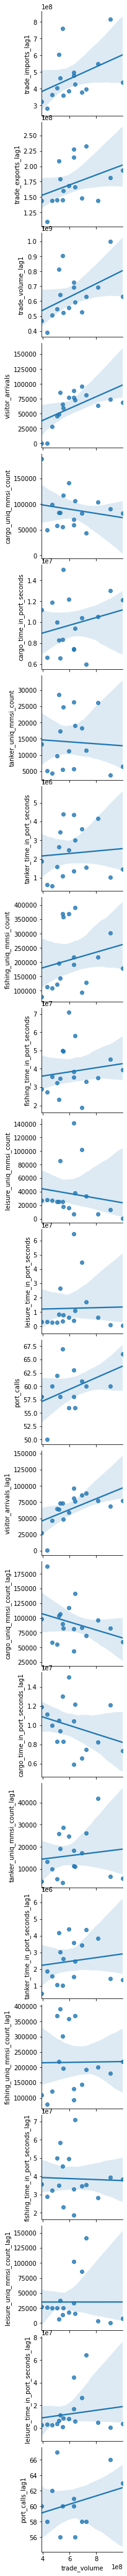

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.pairplot(data[data.country=='fj'],x_vars='trade_volume',y_vars=feature_cols, kind='reg')

In [33]:
['trade_volume'] + feature_cols

['trade_volume',
 'trade_imports_lag1',
 'trade_exports_lag1',
 'trade_volume_lag1',
 'visitor_arrivals',
 'cargo_uniq_mmsi_count',
 'cargo_time_in_port_seconds',
 'tanker_uniq_mmsi_count',
 'tanker_time_in_port_seconds',
 'fishing_uniq_mmsi_count',
 'fishing_time_in_port_seconds',
 'leisure_uniq_mmsi_count',
 'leisure_time_in_port_seconds',
 'port_calls',
 'visitor_arrivals_lag1',
 'cargo_uniq_mmsi_count_lag1',
 'cargo_time_in_port_seconds_lag1',
 'tanker_uniq_mmsi_count_lag1',
 'tanker_time_in_port_seconds_lag1',
 'fishing_uniq_mmsi_count_lag1',
 'fishing_time_in_port_seconds_lag1',
 'leisure_uniq_mmsi_count_lag1',
 'leisure_time_in_port_seconds_lag1',
 'port_calls_lag1']

In [35]:
data.loc[(data.country=='fj'),(['trade_volume'] + feature_cols)]\
.corr()['trade_volume']

trade_volume                         1.000000
trade_imports_lag1                   0.409722
trade_exports_lag1                   0.387647
trade_volume_lag1                    0.463721
visitor_arrivals                     0.578927
cargo_uniq_mmsi_count               -0.186529
cargo_time_in_port_seconds           0.234556
tanker_uniq_mmsi_count              -0.057467
tanker_time_in_port_seconds          0.081374
fishing_uniq_mmsi_count              0.208431
fishing_time_in_port_seconds         0.143307
leisure_uniq_mmsi_count             -0.150246
leisure_time_in_port_seconds         0.022521
port_calls                           0.434418
visitor_arrivals_lag1                0.582290
cargo_uniq_mmsi_count_lag1          -0.320744
cargo_time_in_port_seconds_lag1     -0.291957
tanker_uniq_mmsi_count_lag1          0.116514
tanker_time_in_port_seconds_lag1     0.144397
fishing_uniq_mmsi_count_lag1         0.010100
fishing_time_in_port_seconds_lag1   -0.034937
leisure_uniq_mmsi_count_lag1      

In [39]:
import matplotlib.style as style
import seaborn as sns
style.use('fivethirtyeight')

''

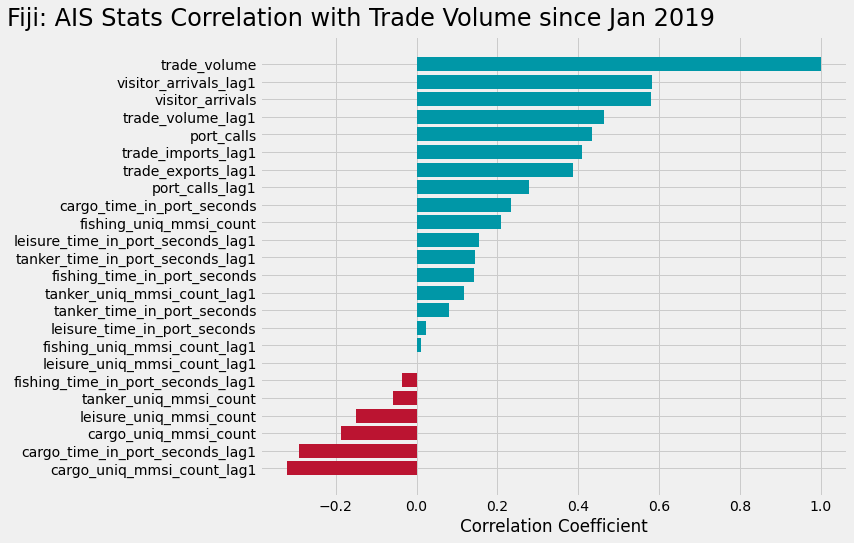

In [44]:
coef = data.loc[(data.country=='fj'),(['trade_volume'] + feature_cols)].corr()\
.sort_values(by='trade_volume',ascending=True)['trade_volume']
# coef = data_model.drop(columns=['fishing_uniq_mmsi_count'
#                                 ,'fishing_time_in_port_seconds'
#                                 ,'gdp'
#                                 ,'gdp_growth_annualised']).corr()\

plt.clf
f = plt.figure(figsize=(12,8))
plt.barh(coef.index
        ,coef
        ,color=(coef>0).map({True:'#0097a7',False:'#bb1431'}))

plt.xlabel('Correlation Coefficient')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Fiji: AIS Stats Correlation with Trade Volume since Jan 2019\n',x=0.01, y=.975,fontsize=24,ha='left')
#plt.figtext(0.01,0.87,'Based on 6 quarterly measures',fontdict={'fontsize':18,'ha':'left'})    
;

# Fit Linear Regressors
Starting with FJ

In [45]:
from sklearn.metrics import mean_squared_error
?mean_squared_error

In [64]:
# 17 samples
data_prep = data[(data.country=='fj')&(~data.trade_volume.isna())].copy()
data_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 20 to 36
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   date_from                          17 non-null     datetime64[ns]
 1   date_to                            17 non-null     datetime64[ns]
 2   region                             17 non-null     object        
 3   country                            17 non-null     object        
 4   trade_imports                      17 non-null     float64       
 5   trade_exports                      17 non-null     float64       
 6   trade_volume                       17 non-null     float64       
 7   trade_imports_lag1                 17 non-null     float64       
 8   trade_exports_lag1                 17 non-null     float64       
 9   trade_volume_lag1                  17 non-null     float64       
 10  visitor_arrivals                   17 n

In [66]:
# fill NA's with mean
data_prep.port_calls.fillna(data_prep.port_calls.mean(),inplace=True)
data_prep.port_calls_lag1.fillna(data_prep.port_calls_lag1.mean(),inplace=True)

In [50]:
# common sense baseline
np.sqrt(mean_squared_error(data_prep.trade_volume,data_prep.trade_volume_lag1))

162231830.7780609

Fit a ridge regression

In [91]:
X = data_prep[feature_cols]
y = data_prep.trade_volume

In [92]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [93]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 30 to 25
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   trade_imports_lag1                 12 non-null     float64
 1   trade_exports_lag1                 12 non-null     float64
 2   trade_volume_lag1                  12 non-null     float64
 3   visitor_arrivals                   12 non-null     float64
 4   cargo_uniq_mmsi_count              12 non-null     int64  
 5   cargo_time_in_port_seconds         12 non-null     int64  
 6   tanker_uniq_mmsi_count             12 non-null     float64
 7   tanker_time_in_port_seconds        12 non-null     float64
 8   fishing_uniq_mmsi_count            12 non-null     float64
 9   fishing_time_in_port_seconds       12 non-null     float64
 10  leisure_uniq_mmsi_count            12 non-null     float64
 11  leisure_time_in_port_seconds       12 non-null     float64


In [126]:
feature_ais = ['cargo_uniq_mmsi_count','cargo_time_in_port_seconds','tanker_uniq_mmsi_count','tanker_time_in_port_seconds',
              'fishing_uniq_mmsi_count','fishing_time_in_port_seconds','leisure_uniq_mmsi_count','leisure_time_in_port_seconds',
              'port_calls',
              'cargo_uniq_mmsi_count_lag1','cargo_time_in_port_seconds_lag1','tanker_uniq_mmsi_count_lag1','tanker_time_in_port_seconds_lag1',
              'fishing_uniq_mmsi_count_lag1','fishing_time_in_port_seconds_lag1','leisure_uniq_mmsi_count_lag1','leisure_time_in_port_seconds_lag1',
              'port_calls_lag1'
              ]

In [94]:
# we're getting to small data
display(X_train.shape,X_test.shape)

(12, 23)

(5, 23)

In [95]:
# use RidgeCV to select best alpha
from sklearn.linear_model import RidgeCV
alpha_range = 10.**np.arange(-2, 3)
rregcv = RidgeCV(normalize=True, scoring='neg_mean_squared_error', alphas=alpha_range)
rregcv.fit(X_train, y_train)

# Print the optimal value of Alpha for Ridge Regression
print('Optimal Alpha Value: ', rregcv.alpha_)

# Print the RMSE for the ridge regression model
preds = rregcv.predict(X_test)
print ('RMSE (Ridge CV reg.) =', np.sqrt(mean_squared_error(y_test, preds)))
# What is the range of alpha values we are searching over?

Optimal Alpha Value:  10.0
RMSE (Ridge CV reg.) = 92611275.05083962


In [96]:
(162231830.7780609-92611275.05083962)/92611275.05083962

0.7517503207790045

In [75]:
len('162231830')

9

In [97]:
len('92611275')

8

In [98]:
def pretty_print_linear(coefs, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return " + ".join("%s * %s" % (round(coef, 3), name)
                                   for coef, name in lst)
  
print("Ridge model: ", pretty_print_linear(rregcv.coef_, feature_cols, sort = True))

Ridge model:  2513687.683 * port_calls_lag1 + 1101418.516 * port_calls + -317.661 * leisure_uniq_mmsi_count + 305.737 * visitor_arrivals_lag1 + 277.579 * visitor_arrivals + 191.992 * tanker_uniq_mmsi_count_lag1 + -133.281 * tanker_uniq_mmsi_count + -108.159 * cargo_uniq_mmsi_count_lag1 + -72.308 * cargo_uniq_mmsi_count + 38.374 * fishing_uniq_mmsi_count + -24.108 * leisure_uniq_mmsi_count_lag1 + 16.804 * fishing_uniq_mmsi_count_lag1 + 2.599 * cargo_time_in_port_seconds + -2.497 * cargo_time_in_port_seconds_lag1 + 1.651 * tanker_time_in_port_seconds + 1.523 * tanker_time_in_port_seconds_lag1 + 0.472 * fishing_time_in_port_seconds + -0.304 * leisure_time_in_port_seconds + 0.128 * trade_exports_lag1 + 0.101 * leisure_time_in_port_seconds_lag1 + 0.03 * trade_volume_lag1 + 0.027 * trade_imports_lag1 + -0.024 * fishing_time_in_port_seconds_lag1


## what if we remove lagging trade columns?

In [99]:
feature_cols2 = feature_cols[3:]
feature_cols2

['visitor_arrivals',
 'cargo_uniq_mmsi_count',
 'cargo_time_in_port_seconds',
 'tanker_uniq_mmsi_count',
 'tanker_time_in_port_seconds',
 'fishing_uniq_mmsi_count',
 'fishing_time_in_port_seconds',
 'leisure_uniq_mmsi_count',
 'leisure_time_in_port_seconds',
 'port_calls',
 'visitor_arrivals_lag1',
 'cargo_uniq_mmsi_count_lag1',
 'cargo_time_in_port_seconds_lag1',
 'tanker_uniq_mmsi_count_lag1',
 'tanker_time_in_port_seconds_lag1',
 'fishing_uniq_mmsi_count_lag1',
 'fishing_time_in_port_seconds_lag1',
 'leisure_uniq_mmsi_count_lag1',
 'leisure_time_in_port_seconds_lag1',
 'port_calls_lag1']

In [100]:
X2 = data_prep[feature_cols2]
y2 = data_prep.trade_volume
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=1)

alpha_range = 10.**np.arange(-2, 3)
rregcv = RidgeCV(normalize=True, scoring='neg_mean_squared_error', alphas=alpha_range)
rregcv.fit(X2_train, y2_train)

# Print the optimal value of Alpha for Ridge Regression
print('Optimal Alpha Value: ', rregcv.alpha_)

# Print the RMSE for the ridge regression model
preds = rregcv.predict(X2_test)
print ('RMSE (Ridge CV reg.) =', np.sqrt(mean_squared_error(y2_test, preds)))
# What is the range of alpha values we are searching over?

Optimal Alpha Value:  1.0
RMSE (Ridge CV reg.) = 167726744.0638591


In [88]:
len('167726744')

9

In [90]:
# 3% worse
(167726744-162231830)/167726744

0.03276110815100542

## what about other regressors?

In [101]:
from sklearn.ensemble import RandomForestRegressor

In [102]:
rfreg = RandomForestRegressor()
rfreg.fit(X_train, y_train)
preds = rfreg.predict(X_test)
print ('RMSE (Random Forest Reg.) =', np.sqrt(mean_squared_error(y2_test, preds)))

RMSE (Random Forest Reg.) = 75691079.77269375


In [104]:
len('75691079')

8

Feature: 0, Score: 0.01223
Feature: 1, Score: 0.02883
Feature: 2, Score: 0.02721
Feature: 3, Score: 0.05966
Feature: 4, Score: 0.00455
Feature: 5, Score: 0.08715
Feature: 6, Score: 0.02068
Feature: 7, Score: 0.00555
Feature: 8, Score: 0.00831
Feature: 9, Score: 0.02584
Feature: 10, Score: 0.16785
Feature: 11, Score: 0.05573
Feature: 12, Score: 0.01320
Feature: 13, Score: 0.14041
Feature: 14, Score: 0.03412
Feature: 15, Score: 0.03821
Feature: 16, Score: 0.02647
Feature: 17, Score: 0.00961
Feature: 18, Score: 0.01755
Feature: 19, Score: 0.00934
Feature: 20, Score: 0.12159
Feature: 21, Score: 0.01108
Feature: 22, Score: 0.07481


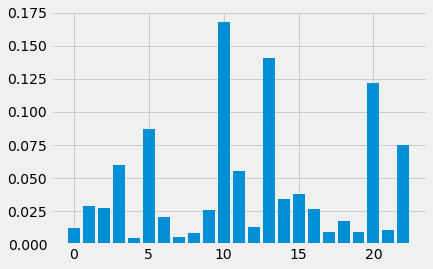

In [106]:
# get importance
importance = rfreg.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [120]:
feature_importances = pd.DataFrame(rfreg.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=True)

In [123]:
feature_importances.to_csv('../data/processed/feature_importances.csv')

<AxesSubplot:>

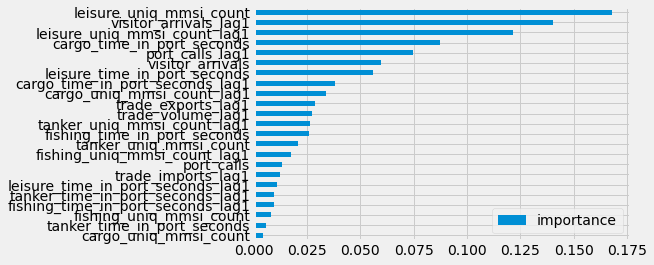

In [121]:

feature_importances.plot.barh()

# What about AIS datapoints only?

In [127]:
X3 = data_prep[feature_ais]
y3 = data_prep.trade_volume
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, random_state=1)

In [128]:
rfreg = RandomForestRegressor()
rfreg.fit(X3_train, y3_train)
preds = rfreg.predict(X3_test)
print ('RMSE (Random Forest Reg.) =', np.sqrt(mean_squared_error(y3_test, preds)))

RMSE (Random Forest Reg.) = 118656304.27604431


In [130]:
len('118656304')

9

<AxesSubplot:ylabel='Feature'>

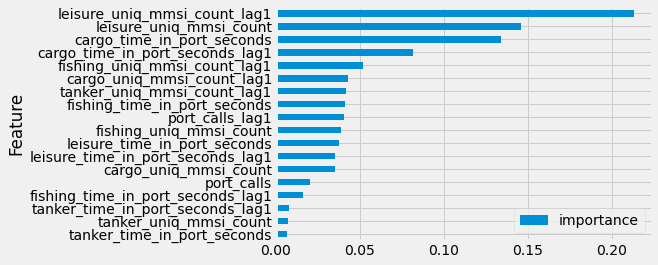

In [135]:
feature_importances = pd.DataFrame(rfreg.feature_importances_,
                                   index = X3_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=True)
feature_importances.index.name = 'Feature'
feature_importances.plot.barh()

''

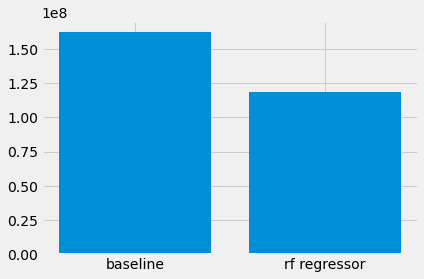

In [134]:
plt.bar(['baseline','rf regressor'],[162231830,118656304])
;

In [136]:
feature_importances.to_csv('../data/processed/feature_importances2.csv')

In [142]:
data_fj_plot = data.loc[((data.country=='fj')),:].copy()
data_fj_plot.port_calls.fillna(data_fj_plot.port_calls.mean(),inplace=True)
data_fj_plot.port_calls_lag1.fillna(data_fj_plot.port_calls_lag1.mean(),inplace=True)
data_fj_plot['trade_volume_prep'] = rfreg.predict(data_fj_plot[feature_ais])

In [146]:
data_fj_plot.to_csv('../data/processed/fj_preds.csv',index=False)

In [144]:
data_fj_plot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 20 to 39
Data columns (total 31 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   date_from                          20 non-null     datetime64[ns]
 1   date_to                            20 non-null     datetime64[ns]
 2   region                             20 non-null     object        
 3   country                            20 non-null     object        
 4   trade_imports                      17 non-null     float64       
 5   trade_exports                      17 non-null     float64       
 6   trade_volume                       17 non-null     float64       
 7   trade_imports_lag1                 18 non-null     float64       
 8   trade_exports_lag1                 18 non-null     float64       
 9   trade_volume_lag1                  18 non-null     float64       
 10  visitor_arrivals                   18 n

In [137]:
forecast_x = data.loc[((data.country=='fj')&(data.trade_volume.isna())),feature_ais]
forecast_y = rfreg.predict(X3_test)

,cargo_uniq_mmsi_count,cargo_time_in_port_seconds,tanker_uniq_mmsi_count,tanker_time_in_port_seconds,fishing_uniq_mmsi_count,fishing_time_in_port_seconds,leisure_uniq_mmsi_count,leisure_time_in_port_seconds,port_calls,cargo_uniq_mmsi_count_lag1,cargo_time_in_port_seconds_lag1,tanker_uniq_mmsi_count_lag1,tanker_time_in_port_seconds_lag1,fishing_uniq_mmsi_count_lag1,fishing_time_in_port_seconds_lag1,leisure_uniq_mmsi_count_lag1,leisure_time_in_port_seconds_lag1,port_calls_lag1
37,79404,6366835,6875.0,1039820.0,147215.0,28237457.0,39209.0,3107945.0,40.0,49919,6621937,5258.0,627976.0,113947.0,27318961.0,28085.0,3069822.0,50.0
38,45817,6913864,3318.0,1019894.0,181624.0,38064473.0,29353.0,3904477.0,63.0,79404,6366835,6875.0,1039820.0,147215.0,28237457.0,39209.0,3107945.0,40.0
39,88595,11403343,5648.0,758154.0,183698.0,37243945.0,509.0,200660.0,40.0,45817,6913864,3318.0,1019894.0,181624.0,38064473.0,29353.0,3904477.0,63.0


# Scratch

In [78]:
# use LassoCV to select best alpha (tries 100 alphas by default)
from sklearn.linear_model import LassoCV
alpha_range = 10.**np.arange(-5, 5)
print(alpha_range)
lascv = LassoCV(normalize=True, alphas=alpha_range)
lascv.fit(X_train, y_train)
print('Optimal Alpha Value: ',lascv.alpha_)
lascv.coef_
preds = lascv.predict(X_test)
print('RMSE (Lasso CV reg.) =', np.sqrt(mean_squared_error(y_test, preds)))

[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
Optimal Alpha Value:  10000.0
RMSE (Lasso CV reg.) = 293019052.6171153


/anaconda3/envs/ais-hack/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64597338510400.43, tolerance: 25186656308348.78
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/ais-hack/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30557093676481.797, tolerance: 30166696459245.793
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/ais-hack/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132294172513313.78, tolerance: 33991209703160.957
  model = cd_fast.enet_coordinate_descent(
/anaconda3/envs/ais-hack/lib/python3.8/site-packages/sklearn/linear_model/_

In [103]:
len('293019052')

9

In [80]:
print("Lasso model: ", pretty_print_linear(lascv.coef_, feature_cols, sort = True))

Lasso model:  33449660.684 * port_calls_lag1 + 3754408.525 * port_calls + -4741.511 * leisure_uniq_mmsi_count + 4528.793 * cargo_uniq_mmsi_count_lag1 + 4336.544 * visitor_arrivals + -3052.265 * tanker_uniq_mmsi_count_lag1 + -2558.186 * tanker_uniq_mmsi_count + 1873.597 * leisure_uniq_mmsi_count_lag1 + 991.767 * fishing_uniq_mmsi_count_lag1 + -409.062 * fishing_uniq_mmsi_count + 44.131 * cargo_time_in_port_seconds + -38.463 * cargo_time_in_port_seconds_lag1 + 31.272 * tanker_time_in_port_seconds + -8.337 * tanker_time_in_port_seconds_lag1 + -2.661 * fishing_time_in_port_seconds_lag1 + 2.186 * leisure_time_in_port_seconds + 0.941 * leisure_time_in_port_seconds_lag1 + 0.045 * trade_imports_lag1 + 0.019 * trade_volume_lag1 + 0.0 * trade_exports_lag1 + 0.0 * cargo_uniq_mmsi_count + -0.0 * fishing_time_in_port_seconds + 0.0 * visitor_arrivals_lag1


In [125]:
data.loc[(data.country=='fj'),['date_from','visitor_arrivals']]

,date_from,visitor_arrivals
20,2019-01-01,63807.0
21,2019-02-01,48748.0
22,2019-03-01,59306.0
23,2019-04-01,76813.0
24,2019-05-01,73169.0
25,2019-06-01,85652.0
26,2019-07-01,96376.0
27,2019-08-01,88834.0
28,2019-09-01,81354.0
29,2019-10-01,77467.0
